In [1]:
# Module import
from IPython.display import Image
import sys
import pandas as pd

# To use interact -- IPython widget
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


# append to path the folder that contains the analytic scanner
sys.path.append('../GaiaLab/scan/analytic_scanner')
# local imports
#from gaia_analytic_toymodel import *

from scipy import interpolate
import timeit

import frame_transformations as ft
from scanner import Scanner
from satellite import Satellite
from source import Source

import constants as const

from quaternion import Quaternion
from agis import Agis
from agis import Calc_source
from agis_functions import *

from analytic_plots import *

# Ipython magics
%load_ext autoreload
%autoreload 2
# %matplotlib notebook 
# %matplotlib widget
# %matplotlib ipympl

# Set some user-specific variables
# MAIN_FOLDER = '../' # relative path to project folder
# FIG_FOLDER = 'figures/' # relative path to figure

# functions definitions:

In [2]:
def error_in_attitude(my_times, Solver, gaia):
    error_in_attitude = 0
    for t in my_times:
        agis_att = Solver.get_attitude(t)
        gaia_att = gaia.func_attitude(t)
        diff_att_w = gaia_att.w - agis_att.w
        error_in_attitude += diff_att.compute_magnitude()
    return error_in_attitude

def error_between_func_attitudes(my_times, func_att1, func_att2):
    error_in_attitude = 0
    for t in my_times:
        diff_att = 0
        att1 = func_att1(t) 
        att2 = func_att2(t)
        diff_att += np.abs(att2.w - att1.w)
        diff_att += np.abs(att2.x - att1.x)
        diff_att += np.abs(att2.y - att1.y)
        diff_att += np.abs(att2.z - att1.z)
        error_in_attitude += np.abs(diff_att)
    return error_in_attitude
    

# Initializing objects:

In [91]:
# # create all the objects we will need:
# parameters for the notebook
t_init = 1/24/60
t_end = t_init + 1/24/60 # 365*5
my_dt = 1/24/60/60# [days]

# objects
# k is the spline degree
spline_order = 3
gaia = Satellite(ti=t_init, tf=t_end, dt= my_dt, k=spline_order)
print('Sat created')
my_times = np.linspace(t_init, t_end, num=1000, endpoint=False)
real_sources = []
calc_sources = []
for t in my_times:
    alpha, delta = generate_observation_wrt_attitude(gaia.func_attitude(t))
    real_src_tmp = Source(str(t),np.degrees(alpha), np.degrees(delta), 0, 0, 0, 0)
    calc_src_tmp = Calc_source('calc_'+str(t), [t], real_src_tmp.get_parameters()[0:5], real_src_tmp.get_parameters()[5])
    real_sources.append(real_src_tmp)
    calc_sources.append(calc_src_tmp)
print('Sources created!')

Sat created
Sources created!


len(real_sources):  1000


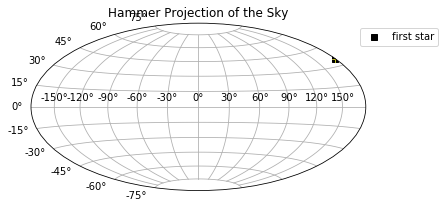

In [92]:
plt.figure()
plt.subplot(111, projection="hammer")
alphas = []
deltas = []
#print('my_times: ', my_times)
print('len(real_sources): ', len(real_sources))
for i, s in enumerate(real_sources):
    alpha, delta = s.alpha-np.pi, s.delta
    #print(i, alpha, delta)
    alphas.append(alpha)
    deltas.append(delta)
    if i==0:
        plt.plot(alpha, delta, 'sk', label='first star')
    else:
        plt.plot( alpha, delta,'+')

plt.title("Hammer Projection of the Sky")
plt.legend(loc=9, bbox_to_anchor=(1.1, 1))
plt.grid(True)

In [93]:
# test if source and calc source are equal (as they should be)
np.testing.assert_array_almost_equal(np.array(real_sources[0].get_parameters()[0:5]), calc_sources[0].s_params)

In [94]:
# create Solver
Solver = Agis(gaia, calc_sources, real_sources, attitude_splines=[gaia.s_w, gaia.s_x, gaia.s_y, gaia.s_z], spline_order=spline_order,
             attitude_regularisation_factor=1e-2)

## Tests:

In [74]:
c_noise = Solver.att_coeffs * np.random.rand(Solver.att_coeffs.shape[0], Solver.att_coeffs.shape[1]) * 0.01
print('c_noise shape: ', c_noise.shape)
Solver.att_coeffs = Solver.att_coeffs + c_noise
Solver.actualise_splines()

c_noise shape:  (4, 11)


In [75]:
error_between_func_attitudes(my_times, gaia.func_attitude, Solver.get_attitude)

2.642925730512121

In [76]:
Solver.error_function()

0.002203946288244468

In [44]:
Solver.att_coeffs.shape

(4, 16)

In [45]:
Solver.set_splines_basis()

In [46]:
Solver.att_bases[0].shape

(16, 20)

(16, 20)
0.0006944444444444444 to 0.0013541666666666665


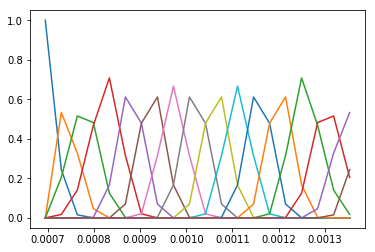

In [47]:
basis = get_basis_Bsplines(knots=Solver.att_knots[0,:], coeffs=Solver.att_coeffs[0,:], k=Solver.k, obs_times=my_times)
for b in basis:
    plt.plot(my_times, b)
print(basis.shape)
print(my_times[0], 'to', my_times[-1])

In [48]:
# given the spline: 
m = 10 # [0-100]
M = 5
knots = Solver.att_knots[0]
coeffs = Solver.att_coeffs[0]
bases = Solver.att_bases[0]

observed_times = Solver.all_obs_times[(knots[m]<=Solver.all_obs_times) & (Solver.all_obs_times<=knots[m+M]) ]
print(observed_times[0])
if not list(observed_times):
    raise ValueError('not observed times in interval')

t = observed_times[0]
index = np.where(Solver.all_obs_times==t)[0][0]

tau_l = np.where(knots<=t)
# print('tau_l: ',tau_l)
if not list(tau_l[0]):
    L=0
else:
    L=tau_l[0][-1]
    if L-M>=0:
        L=L-M
print('t:', t)
b_list = []
N = len(coeffs)
for i, n in enumerate(range(L, L+M+1)): # last +1 because range does not inlude the last point
    print(i)
    coeff = coeffs[n]
    bspline = bases[n]
    b_list.append(coeff*bspline)
c = compute_attitude_deviation(Solver.att_coeffs, Solver.att_bases, L, M, index)
print(Solver.att_bases[:, L:L+M, :].shape)
print(Solver.att_coeffs[:, L:L+M].reshape(4, -1, 1).shape)
print((Solver.att_bases[:, L:L+M, :] * Solver.att_coeffs[:, L:L+M].reshape(4, -1, 1)).shape)
# c = sum((Solver.att_bases[:, L:L+M, :].transpose(0,2,1) * coeffs[L:L+M]).transpose(0,2,1))
#c = np.sum(Solver.att_bases[:, L:L+M, :] * Solver.att_coeffs[:, L:L+M].reshape(4, -1, 1), axis=1)
b = sum(b_list)
a = sum([coeff*bspline for coeff, bspline in zip(Solver.att_coeffs[0], Solver.att_bases[0])])
print('man3al: ', c[ 0])
print('man2al: ', b[index])
print('manual: ', a[index])
print('artifi: ', BSpline(Solver.att_knots[0], Solver.att_coeffs[0], k=3)(t))

0.0010763888888888887
t: 0.0010763888888888887
0
1
2
3
4
5


TypeError: compute_attitude_deviation() takes 1 positional argument but 5 were given

In [49]:
for i in range(Solver.att_coeffs.shape[1]):
    Solver.att_coeffs[:,i] /= np.linalg.norm(Solver.att_coeffs[:,i])

In [50]:
Solver.reset_iterations()

In [46]:
Solver.verbose=False
Solver.reset_iterations()
Solver.iterate(1)

***** Iteration: 1 *****
17
38.643598853099626
Error after iteration: 35.042922185445654


In [41]:
Solver.att_coeffs[:,6]

array([ 0.60433869,  0.79137405, -0.087041  ,  0.03042582])

In [90]:
Solver.iterate(10)

***** Iteration: 1 *****
16
43.61807596873684
Error after iteration: 13.750247394455922
***** Iteration: 2 *****
16
44.6740067229348
Error after iteration: 25.804597440045818
***** Iteration: 3 *****
16
47.84184170519934
Error after iteration: 117.61277374304105
***** Iteration: 4 *****
16


../GaiaLab/scan/analytic_scanner/quaternion.py:47: RuntimeWarning: overflow encountered in square
  self.magnitude = np.sqrt(self.w**2 + self.x**2 + self.y**2 + self.z**2)
../GaiaLab/scan/analytic_scanner/agis.py:364: RuntimeWarning: invalid value encountered in multiply
  regularisation_part = self.attitude_regularisation_factor**2 * dDL_da_n * D_L


34.644876571649526
Error after iteration: 1.379985764305532e-31
***** Iteration: 5 *****
16


LinAlgError: Singular matrix

In [95]:
N_aa = Solver.compute_attitude_LHS()
print('N_aa computed')
h = Solver.compute_attitude_RHS()
print('shape of h: ', h.shape)
print('h/4: ', h.shape[0]/4)

61
N_aa computed
shape of h:  (244, 1)
h/4:  61.0


In [96]:
print('my_times shape:', my_times.shape)
print('coeffs shape:',Solver.att_coeffs.shape)
print('Matrix dimension: ', N_aa.shape)
print('Is the matrix symmetric? ', helpers.check_symmetry(N_aa))
eig_vals, eig_vecs = np.linalg.eigh(N_aa)
print('Condition number: ', np.linalg.cond(N_aa))
print('min-max eig_vals: ',eig_vals.min(), eig_vals.max())
print('Condition number (eig_max/eig_min): ', np.abs(eig_vals.max())/np.abs(eig_vals.min()))
print('Rank: ', np.linalg.matrix_rank(N_aa, hermitian=True))
print('det(N_aa):', np.linalg.det(N_aa))
print('smallest eig_vals: ', np.sort(eig_vals)[0:5])
print('eigenvalues: ', eig_vals)
print('eig_vals product: ', np.prod(eig_vals))
print(N_aa)

my_times shape: (1000,)
coeffs shape: (4, 61)
Matrix dimension:  (244, 244)
Is the matrix symmetric?  True
Condition number:  2.139506768791923e+18
min-max eig_vals:  -2.4522014779261398e-14 136.2869636405502
Condition number (eig_max/eig_min):  5557739234208844.0
Rank:  169
det(N_aa): 0.0
smallest eig_vals:  [-2.45220148e-14 -2.14001937e-14 -1.84595497e-14 -1.64332733e-14
 -1.61664441e-14]
eigenvalues:  [-2.45220148e-14 -2.14001937e-14 -1.84595497e-14 -1.64332733e-14
 -1.61664441e-14 -1.56946655e-14 -1.34979002e-14 -1.23241135e-14
 -1.15077894e-14 -1.06602950e-14 -9.56594572e-15 -9.28768550e-15
 -9.14798266e-15 -8.76875447e-15 -8.10986881e-15 -7.98839941e-15
 -7.69200836e-15 -7.51111335e-15 -7.07108201e-15 -6.63905724e-15
 -6.54942381e-15 -5.70616165e-15 -5.66804574e-15 -5.24874659e-15
 -4.82614558e-15 -4.59915772e-15 -4.34720807e-15 -2.91286620e-15
 -2.87065543e-15 -2.22423914e-15 -2.02038598e-15 -1.71760994e-15
 -1.68589994e-15 -8.48096053e-16 -6.90296644e-16 -2.73941552e-16
  2.262

In [62]:
Solver.att_coeffs[:, 0]

array([ 0.80012573, -0.52422793,  0.25684519, -0.15906222])

In [79]:
print('my_times shape:', my_times.shape)
print('coeffs shape:',Solver.att_coeffs.shape)
print('det(N_aa):', np.linalg.det(N_aa))
print('eigenvalues: ', eig_vals)
np.prod(eig_vals)

my_times shape: (1000,)
coeffs shape: (4, 11)
det(N_aa): -1.3116263322083113e-171
eigenvalues:  [-3.01992566e-14 -1.92683952e-14  1.84268657e-12  3.93736481e-12
  1.26702779e-11  2.34820753e-10  6.35495420e-10  1.38522027e-09
  1.00866095e-08  2.88299445e-08  4.49881774e-08  6.19190248e-08
  7.47863701e-07  4.69218633e-06  8.38148803e-06  1.67561944e-05
  3.36325854e-05  8.72253575e-05  1.07166540e-04  1.43299147e-04
  1.69317049e-04  3.57967667e-04  4.00071845e-04  5.49834671e-04
  7.58261433e-04  8.13700770e-04  1.18915733e-03  1.52570603e-03
  1.75653598e-03  1.98476989e-03  2.59966107e-03  3.39892160e-03
  3.62016201e-03  3.24211937e+01  3.75113689e+01  8.49491441e+01
  1.37288231e+02  1.83839708e+02  2.71140012e+02  3.64498269e+02
  4.45037873e+02  5.94184115e+02  7.78572468e+02  8.31268446e+02]


1.4598119992414942e-170

In [34]:
print(Solver.att_coeffs.shape)
print(Solver.att_knots.shape)
print(Solver.M)

(4, 17)
(4, 21)
4


In [13]:
if np.linalg.det(N_aa) > 0:
    L = np.linalg.cholesky(N_aa)
    print(L)
else: 
    print('Determinant of N_aa not positive')
np.linalg.solve(N_aa, h)[0:5]

Determinant of N_aa not positive


array([[-845.02076892],
       [-344.65191102],
       [   9.71322428],
       [ -69.6       ],
       [  47.76213266]])

In [36]:
N_aa_dim = Solver.att_coeffs.shape[1]
RHS = np.zeros((N_aa_dim*4, 1))
for n in range(0, N_aa_dim):
    RHS[n*4:n*4+4] = Solver.compute_attitude_RHS_n(n)
print(RHS.shape)

(68, 1)


In [37]:
rhs = np.zeros((4, 1))
n_index = 4
observed_times = get_times_in_knot_interval(Solver.all_obs_times, Solver.att_knots[0], n_index, Solver.M)
for i, t_L in enumerate(observed_times):
    source_index = Solver.get_source_index(t_L)
    calc_source = Solver.calc_sources[source_index]
    attitude = Solver.get_attitude(t_L)
    left_index = get_left_index(Solver.att_knots[0], t_L, M=Solver.M)
    obs_time_index = list(Solver.all_obs_times).index(t_L)

    # Compute the regulation part
    coeff_basis_sum = compute_coeff_basis_sum(Solver.att_coeffs, Solver.att_bases,
                                              left_index, Solver.M, obs_time_index)
    D_L = compute_attitude_deviation(coeff_basis_sum)
    dDL_da_n = compute_DL_da_i(coeff_basis_sum, Solver.att_bases, obs_time_index, n_index)
    regulation_part = Solver.attitude_regularisation_factor**2 * dDL_da_n * D_L

    # # WARNING: Here we put the Across scan and the along scan together
    dR_dq = compute_dR_dq(calc_source, Solver.sat, attitude, t_L)
    dR_da_n = dR_da_i(dR_dq, Solver.att_bases[:, n_index, obs_time_index])
    R_L = Solver.compute_attitude_R_L(source_index, attitude, t_L)
    rhs += dR_da_n * R_L + regulation_part.reshape(4,-1)
    print(regulation_part)
    #print(dR_da_n * R_L)
print(rhs)

AttributeError: 'Agis' object has no attribute 'compute_attitude_R_L'

In [38]:
dR_dq = compute_dR_dq(Solver.calc_sources[0], Solver.sat, Solver.get_attitude(t), )
dR_da_i(dR_dq, Solver.att_bases[:, n_index, obs_time_index])

TypeError: compute_dR_dq() missing 1 required positional argument: 't'

In [39]:
print(h)

[[   1.84915048]
 [  -3.80287831]
 [ -14.85711093]
 [  -5.20756582]
 [   3.39345468]
 [  -6.6828352 ]
 [ -24.69252675]
 [  -8.29540965]
 [   5.59254533]
 [  -9.97101641]
 [ -35.10255587]
 [ -10.8659821 ]
 [   9.17415464]
 [ -13.63843397]
 [ -47.44340502]
 [ -12.69861214]
 [  10.19051143]
 [ -11.2204245 ]
 [ -41.74926273]
 [  -8.68751371]
 [  13.52264371]
 [ -10.33202305]
 [ -45.49096167]
 [  -6.99000326]
 [  17.93836267]
 [  -8.07516253]
 [ -49.95435412]
 [  -5.16181038]
 [  23.70283658]
 [  -4.11429159]
 [ -55.32140512]
 [  -3.63900321]
 [  31.0702819 ]
 [   1.78885434]
 [ -61.70708913]
 [  -3.08313831]
 [  40.19454946]
 [   9.61649745]
 [ -69.06965256]
 [  -4.375115  ]
 [  50.98001102]
 [  18.88157195]
 [ -77.09182764]
 [  -8.47986547]
 [  62.90474345]
 [  28.45950187]
 [ -85.08306947]
 [ -16.10331307]
 [  74.9349977 ]
 [  36.66787618]
 [ -92.0168009 ]
 [ -27.183845  ]
 [ 108.79304032]
 [  52.29222068]
 [-121.11018691]
 [ -53.73921768]
 [  88.89071957]
 [  39.88947337]
 [ -92.6827232

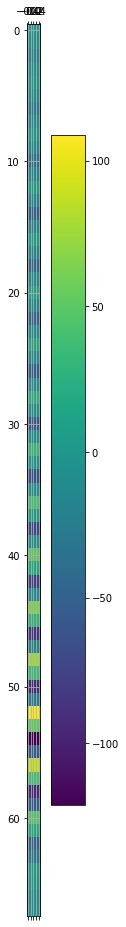

In [40]:
plt.matshow(h, fignum=None)
plt.colorbar()
plt.grid()
plt.show()

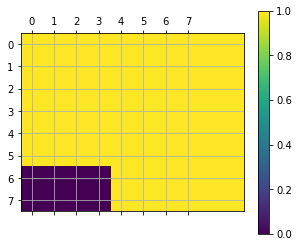

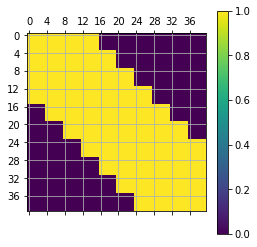

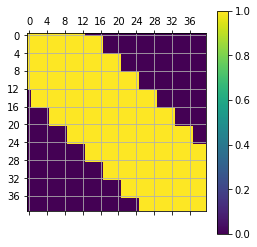

In [80]:
helpers.plot_sparsity_pattern(N_aa[10:18, 0:10], 1)
helpers.plot_sparsity_pattern(N_aa[0:40, 0:40], 4)
helpers.plot_sparsity_pattern(N_aa[-41:-1, -41:-1], 4)

11


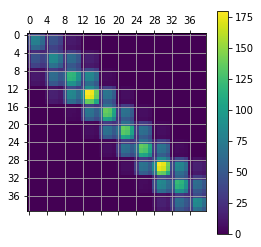

0.0


In [84]:
N_aa = Solver.compute_attitude_LHS()
tol = 1
A = N_aa[0:40, 0:40]
B = A #np.zeros(A.shape)
# B[np.where( np.abs(A) > tol)] = 1
plt.matshow(B, fignum=None)
plt.colorbar()
plt.xticks(np.arange(0, B.shape[0], 4))
plt.yticks(np.arange(0, B.shape[0], 4))
plt.grid()
plt.show()
print(N_aa.min())

0.008942554630203386


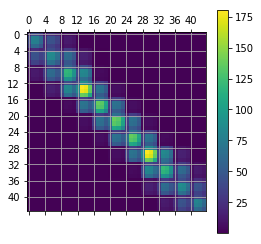

In [83]:
A = N_aa.copy()
A[np.where(A==0)] = 1
print(A.min())
plt.matshow(A, fignum=None)
plt.colorbar()
plt.xticks(np.arange(0, A.shape[0], 4))
plt.yticks(np.arange(0, A.shape[0], 4))
plt.grid()
plt.show()

In [118]:
print(len(my_times))
Solver.att_bases.shape

1000


(4, 17, 1000)

In [100]:
Solver.M

4

In [101]:
a = 2
print(a)

2
